- This code has written by Ahmadreza Attarpour (a.attarpour@mail.utoronto.ca)
- It's a practice to check how we can use LangChain/LangGraph to build tools and agents

-------------------------------------

# Building a chatbot with memory and checkpoint


In [ ]:
####----------------------Build the LLM and embeddings----------------------####

# load the environment variables from the .env file
from dotenv import load_dotenv
import os
load_dotenv()

# Read the variable from the environment and set it as a env variable
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
if GOOGLE_API_KEY:
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
if LANGCHAIN_API_KEY:
    os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
if LANGCHAIN_PROJECT:
    os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
if os.getenv("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
if os.getenv("SERPER_API_KEY"):
    os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"


# # load the LLM and embeddings from langchain_google_genai
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192")

llm.invoke("Hello, how are you?")

AIMessage(content="I'm just a language model, I don't have feelings or emotions like humans do, so I don't have good or bad days. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 16, 'total_tokens': 72, 'completion_time': 0.159011617, 'prompt_time': 0.000197646, 'queue_time': 0.020363418, 'total_time': 0.159209263}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--aa119cc9-63f3-4b84-a2b0-0d9208c6e719-0', usage_metadata={'input_tokens': 16, 'output_tokens': 56, 'total_tokens': 72})

Here is a my call model Function
https://github.com/langchain-ai/langgraph/tree/main/libs/langgraph/langgraph/graph


In [3]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [4]:
#######----------------------function to visualize the app----------------------####
def visualize_app(app):
    """
    Visualize the app using Mermaid syntax.
    """
    try:
        from IPython.display import display, Image
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)

In [5]:
#######----------------------function to stream app----------------------####

def stream_app(app, input_state):
    """
    Stream the app output.
    """
    for output in app.stream(input_state):
        for key, value in output.items():
            print(f"Output from {key} Node")
            print("-------------------")

            print(value)
            print("\n")


Notes: in the previous script we defined a custom state, but here we will use the MessagesState which is a prebuilt state in langgraph.

MessagesState is what we float between nodes of the graph; it contains human, AI, and tools messages. 


In [30]:
####----------------------call LLM model function----------------------####
def call_model(state: MessagesState):

    messages = state['messages']
    response = llm.invoke(messages)

    return {"messages": [response]}

# test the call_model function
state = {"messages": [HumanMessage(content="Hello, how many provinces are in Canada?")]}
call_model(state)

{'messages': [AIMessage(content='There are 10 provinces in Canada:\n\n1. Ontario\n2. Quebec\n3. British Columbia\n4. Alberta\n5. Saskatchewan\n6. Manitoba\n7. Nova Scotia\n8. New Brunswick\n9. Prince Edward Island\n10. Newfoundland and Labrador\n\nAdditionally, there are 3 territories in Canada:\n\n1. Yukon\n2. Northwest Territories\n3. Nunavut\n\nSo, in total, there are 10 provinces and 3 territories in Canada!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 19, 'total_tokens': 118, 'completion_time': 0.289310129, 'prompt_time': 0.000303445, 'queue_time': 0.009226708, 'total_time': 0.289613574}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6eaf3d20-aa70-42c8-8b59-558a5a525001-0', usage_metadata={'input_tokens': 19, 'output_tokens': 99, 'total_tokens': 118})]}

In [31]:
#######----------------------build a simple chatbot----------------------####

workflow = StateGraph(MessagesState)
workflow.add_node("chatbot", call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

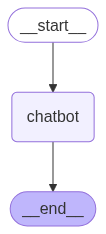

In [32]:
#######----------------------visualize the app----------------------####
visualize_app(app)


In [33]:
# let's run the app

input_state = {"messages": "Hello, my name is Reza from Canada?"}
app.invoke(input_state)

{'messages': [HumanMessage(content='Hello, my name is Reza from Canada?', additional_kwargs={}, response_metadata={}, id='9abaca15-1708-487a-8d06-a02d7e8875be'),
  AIMessage(content="Hello Reza from Canada! Nice to meet you! How's life in Canada treating you?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 20, 'total_tokens': 40, 'completion_time': 0.065179418, 'prompt_time': 0.000311015, 'queue_time': 0.009348739, 'total_time': 0.065490433}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--834c8840-ccca-4ce6-8637-31c1fc74e4d1-0', usage_metadata={'input_tokens': 20, 'output_tokens': 20, 'total_tokens': 40})]}

In [34]:
#######----------------------let's stream it----------------------####
stream_app(app, input_state)

Output from chatbot Node
-------------------
{'messages': [AIMessage(content="Hello Reza from Canada! Nice to meet you! How's life treating you in the Great White North? What brings you here today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 20, 'total_tokens': 49, 'completion_time': 0.092860808, 'prompt_time': 0.000334064, 'queue_time': 0.00947042, 'total_time': 0.093194872}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a55ba541-9d03-4444-8e5b-e5468d49f451-0', usage_metadata={'input_tokens': 20, 'output_tokens': 29, 'total_tokens': 49})]}




In [6]:
###----------------------create a custom tool----------------------####

@tool
def reza_search(query: str):

    """
    this is just a custom tool.
    """
    if 'reza' in query.lower():
        return "Reza is an AI scientist from Canada."
    else:
        return f"I don't about {query}."

# let's test the tool
reza_search.invoke("Who is Ara?")

"I don't about Who is Ara?."

In [36]:
reza_search

StructuredTool(name='reza_search', description='this is just a custom tool.', args_schema=<class 'langchain_core.utils.pydantic.reza_search'>, func=<function reza_search at 0x1523cf9c0>)

In [7]:
tools = [reza_search]


### change the tool to a node in the graph
tool_node = ToolNode(tools)


### bind the llm to the tool.
llm_with_tools = llm.bind_tools(tools)

### update the call_model function to use the llm_with_tools
def call_model(state: MessagesState):

    messages = state['messages']
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

call_model({"messages": [HumanMessage(content="Hello, how many provinces are in Canada?")]})

{'messages': [AIMessage(content='There are 10 provinces in Canada.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 886, 'total_tokens': 895, 'completion_time': 0.054935147, 'prompt_time': 0.035960016, 'queue_time': 0.010541518, 'total_time': 0.090895163}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--724eff20-2cb8-447e-9207-2d7e7a4290e6-0', usage_metadata={'input_tokens': 886, 'output_tokens': 9, 'total_tokens': 895})]}

Let's look the result here: as it shows, there is no tool_calls because our query was not related to 'reza'

{'messages': [AIMessage(content='There are 10 provinces in Canada.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 886, 'total_tokens': 895, 'completion_time': 0.053215394, 'prompt_time': 0.037787415, 'queue_time': 0.015368489, 'total_time': 0.091002809}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d8e831c6-f737-4405-8ef9-c7667b0ac082-0', usage_metadata={'input_tokens': 886, 'output_tokens': 9, 'total_tokens': 895})]}

In [38]:
call_model({"messages": [HumanMessage(content="Hello, who is Reza?")]})

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1mhtmgs4f', 'function': {'arguments': '{"query":"Reza"}', 'name': 'reza_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 884, 'total_tokens': 929, 'completion_time': 0.181218569, 'prompt_time': 0.028161911, 'queue_time': 0.018045852, 'total_time': 0.20938048}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bfeec74c-4af1-46be-8c1a-9e463f08f19f-0', tool_calls=[{'name': 'reza_search', 'args': {'query': 'Reza'}, 'id': '1mhtmgs4f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 884, 'output_tokens': 45, 'total_tokens': 929})]}

Let's look the result here: as it shows, there is tool_calls because our query was related to 'reza'


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9fqnbfnag', 'function': {'arguments': '{"query":"Reza"}', 'name': 'reza_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 884, 'total_tokens': 929, 'completion_time': 0.175338733, 'prompt_time': 0.028429127, 'queue_time': 0.018603705, 'total_time': 0.20376786}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7ebfcfe8-7355-404f-a710-2b432db12d57-0', tool_calls=[{'name': 'reza_search', 'args': {'query': 'Reza'}, 'id': '9fqnbfnag', 'type': 'tool_call'}], usage_metadata={'input_tokens': 884, 'output_tokens': 45, 'total_tokens': 929})]}

# but it doesn't contain any output; content is empty that's why we need a function for our tool, but because we bind this to LLM, we can check if it has tool_calls, we need to call tool; otherwise, LLM itself creates the answer.

In [8]:
#######----------------------Define the router function----------------------####
def router_function(state: MessagesState) -> Literal["tools", END]:
    """
    This function routes the state to the tools if the query is related to 'reza'.
    """
    messages = state['messages']
    last_message = messages[-1] 

    if last_message.tool_calls:
        return "tools"

    return END


In [40]:
####----------------------let's build the graph---------------------####

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_edge(START, "agent")

workflow.add_node("tools", tool_node)

workflow.add_conditional_edges(
    "agent", # starts from here 
    router_function, # this decides the next step
    {"tools": "tools", END: END} # either go to tools or end
)   

app = workflow.compile()


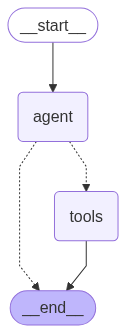

In [41]:
# visualize_app

visualize_app(app)

In [42]:
input_state = {"messages": "Hello, do you know reza?"}
stream_app(app, input_state)

Output from agent Node
-------------------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gsa762vwf', 'function': {'arguments': '{"query":"reza"}', 'name': 'reza_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 885, 'total_tokens': 930, 'completion_time': 0.153842675, 'prompt_time': 0.035739408, 'queue_time': 0.00990121, 'total_time': 0.189582083}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--56973e48-56e1-4057-b7ca-b93c13b67b63-0', tool_calls=[{'name': 'reza_search', 'args': {'query': 'reza'}, 'id': 'gsa762vwf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 885, 'output_tokens': 45, 'total_tokens': 930})]}


Output from tools Node
-------------------
{'messages': [ToolMessage(content='Reza is an AI scientist from Canada.', name='reza_search', id='67fc37bd-472b-4c5d-b8aa-8a

In [43]:
input_state = {"messages": "Hello, where is reza?"}
stream_app(app, input_state)

Output from agent Node
-------------------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0babrw43f', 'function': {'arguments': '{"query":"reza"}', 'name': 'reza_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 884, 'total_tokens': 929, 'completion_time': 0.161033597, 'prompt_time': 0.035777477, 'queue_time': 0.009878882, 'total_time': 0.196811074}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dc4623d0-8c72-4a76-b0b3-ec0ee13a2a2f-0', tool_calls=[{'name': 'reza_search', 'args': {'query': 'reza'}, 'id': '0babrw43f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 884, 'output_tokens': 45, 'total_tokens': 929})]}


Output from tools Node
-------------------
{'messages': [ToolMessage(content='Reza is an AI scientist from Canada.', name='reza_search', id='1d93e4ce-09d3-40d9-972d-0

In [44]:
input_state = {"messages": "Hello, how many provinces are there in Canada?"}
stream_app(app, input_state)

Output from agent Node
-------------------
{'messages': [AIMessage(content='There are 10 provinces in Canada.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 887, 'total_tokens': 896, 'completion_time': 0.055441987, 'prompt_time': 0.035859676, 'queue_time': 0.010197617, 'total_time': 0.091301663}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--83756fbe-0064-4349-9cba-7198c944f0c2-0', usage_metadata={'input_tokens': 887, 'output_tokens': 9, 'total_tokens': 896})]}




Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


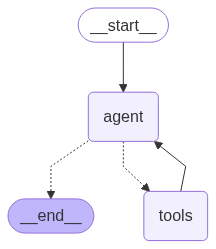

In [45]:
### now let's create a loop from the tools to the agent

workflow.add_edge("tools", "agent")
app = workflow.compile()

visualize_app(app)

In [46]:
input_state = {"messages": "Hello, where is reza? only name the country."}
stream_app(app, input_state)

Output from agent Node
-------------------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1dkmr6xcq', 'function': {'arguments': '{"query":"reza"}', 'name': 'reza_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 889, 'total_tokens': 934, 'completion_time': 0.170970595, 'prompt_time': 0.036426007, 'queue_time': 0.010237299, 'total_time': 0.207396602}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f03390d1-1d00-4dda-8951-15f15d37395f-0', tool_calls=[{'name': 'reza_search', 'args': {'query': 'reza'}, 'id': '1dkmr6xcq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 889, 'output_tokens': 45, 'total_tokens': 934})]}


Output from tools Node
-------------------
{'messages': [ToolMessage(content='Reza is an AI scientist from Canada.', name='reza_search', id='fc8b1dbe-7b07-4d45-8e7d-9

# Now let's add Memory

In [9]:
from langgraph.checkpoint.memory import MemorySaver

# Now let's add Memory
memory = MemorySaver()

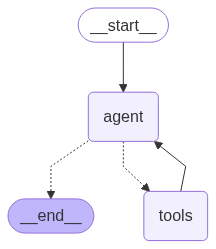

In [10]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_edge(START, "agent")

workflow.add_node("tools", tool_node)

workflow.add_conditional_edges(
    "agent", # starts from here 
    router_function, # this decides the next step
    {"tools": "tools", END: END} # either go to tools or end
)   

workflow.add_edge("tools", "agent")

app = workflow.compile(checkpointer=memory)

visualize_app(app)

In [12]:
#######----------------------we need to create a configuration----------------------####

config = {"configurable": {"thread_id": "1"}} # this is just an example configuration meaning each conversation will have a unique thread_id

In [56]:
events = app.stream({"messages": [HumanMessage(content="Hello, where is reza?")]}, config, stream_mode="values")

In [ ]:
events = app.stream(
    {"messages": [HumanMessage(content="Hello, where is reza?")]},
    config=config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

Hello, where is reza?
================================== Ai Message ==================================

Reza is an AI scientist from Canada.


In [63]:
events = app.stream(
    {"messages": [HumanMessage(content="Hello, my name is Elnaz?")]},
    config=config,
    stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, my name is Elnaz?
================================== Ai Message ==================================

Nice to meet you, Elnaz!


In [64]:
events = app.stream(
    {"messages": [HumanMessage(content="Hello, what's my name?")]},
    config=config,
    stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, what's my name?
================================== Ai Message ==================================

Your name is Elnaz.


In [68]:
memory.get(config)

{'v': 4,
 'ts': '2025-08-08T16:19:53.773827+00:00',
 'id': '1f074738-4462-6e6e-802c-e7afcf178f98',
 'channel_versions': {'__start__': '00000000000000000000000000000045.0.7809072971967554',
  'messages': '00000000000000000000000000000046.0.3904657184713459',
  'branch:to:agent': '00000000000000000000000000000046.0.3904657184713459',
  'branch:to:tools': '00000000000000000000000000000018.0.19519590400590026'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000044.0.5940201652299456'},
  'agent': {'branch:to:agent': '00000000000000000000000000000045.0.7809072971967554'},
  'tools': {'branch:to:tools': '00000000000000000000000000000017.0.45086161521756385'}},
 'channel_values': {'messages': [HumanMessage(content='Hello, where is reza?', additional_kwargs={}, response_metadata={}, id='b0aa12f7-478d-418e-b242-ec392138ac6f'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xd0qt0m0p', 'function': {'arguments': '{"query":"reza"}',